This notebook shows some functions to transform and plot the `tgviz` data.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import umap

from cyvcf2 import VCF, Writer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def vcf2df(vcf_fname):
    """Convert a subsetted vcf file to pandas DataFrame
    and return sample-level population data"""
    samples = 'ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel'
    dfsamples = pd.read_csv(samples, sep='\t')
    dfsamples.set_index('sample', inplace=True)
    dfsamples.drop(columns=['Unnamed: 4', 'Unnamed: 5'], inplace=True)

    vcf_file = VCF(vcf_fname)
    df = pd.DataFrame(index=vcf_file.samples)
    for variant in vcf_file():
        df[variant.ID] = variant.gt_types

    df = df.join(dfsamples, how='outer')
    df = df.drop(columns=['pop', 'super_pop', 'gender'])

    return df, dfsamples

Explore the 55 AISNPs from the Kidd manuscript.

In [3]:
vcf_fname = '../data/Kidd.55AISNP.1kG.vcf'
df, dfsamples = vcf2df(vcf_fname)

In [4]:
# How many samples and AISNPs?
print(df.shape)

# Are the two DataFrames the same length?
print(df.shape[0] == dfsamples.shape[0])

(2504, 55)
True


`df` has sample accessions along the index and each SNP is represented in a column. 

In [5]:
df.head()

,rs3737576,rs7554936,rs2814778,rs798443,rs1876482,rs1834619,rs3827760,rs260690,rs6754311,rs10497191,...,rs17642714,rs4471745,rs11652805,rs2042762,rs7226659,rs3916235,rs4891825,rs7251928,rs310644,rs2024566
HG00096,0,1,0,3,0,0,0,1,0,3,...,0,0,1,0,0,3,3,1,1,0
HG00097,0,3,0,3,0,0,0,0,0,3,...,1,0,3,0,0,3,1,0,0,1
HG00099,0,1,0,1,3,1,0,3,0,3,...,0,0,1,0,0,1,1,0,0,1
HG00100,0,3,0,3,0,0,0,3,1,3,...,1,0,3,1,0,3,3,0,0,0
HG00101,0,1,0,3,1,1,0,3,3,3,...,0,0,3,0,0,3,3,1,0,1


In [6]:
dfsamples.head()

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male


One-hot encode the DataFrame

In [7]:
ncols = len(df.columns)
ohe = OneHotEncoder(categories=[range(4)] * ncols, sparse=False)

X = ohe.fit_transform(df.values)

Now, reduce the dimensionality of the DataFrame.

In [8]:
def reduce_dim(X, algorithm='PCA', n_components=4):
    """Reduce the dimensionality of the 55 AISNPs
    :param X: One-hot encoded 1kG 55 AISNPs.
    :type X: array
    :param algorithm: The type of dimensionality reduction to perform. 
        One of {PCA, UMAP, TSNE}
    :type algorithm: str 
    :param n_components: The number of components to return in X_red 
    :type n_components: int
    
    :returns: The transformed X[m, n] array, reduced to X[m, n_components] by algorithm.
    """
    
    if algorithm == 'PCA':
        X_red = PCA(n_components=n_components).fit_transform(X)
    elif algorithm == 'TSNE':
        # TSNE, Barnes-Hut have dim <= 3
        if n_components > 3:
            print('The Barnes-Hut method requires the dimensionaility to be <= 3')
            return None
        else:
            X_red = TSNE(n_components=n_components, n_jobs=4).fit_transform(X)
    elif algorithm == 'UMAP':
        X_red = umap.UMAP(n_components=n_components).fit_transform(X)
    else:
        return None
    return X_red

In [9]:
X_emb = reduce_dim(X, algorithm='PCA', n_components=3)

In [10]:
X_emb

array([[-1.55299653, -1.86735234, -0.78917887],
       [-1.73080784, -1.8835128 , -0.41816249],
       [-1.9727361 , -2.06077784, -0.24181905],
       ...,
       [-0.76779493, -0.14213636,  0.57205937],
       [-0.69352984, -0.71180017,  0.39526967],
       [-1.43860499,  0.1358469 ,  0.37728335]])

In [11]:
def encode_class(pop_level='pop'):
    """Encode the population lables for plotting."""
    le = LabelEncoder()
    if pop_level == 'pop':
        labels = le.fit_transform(dfsamples['pop'].values)
    elif pop_level == 'super_pop':
        labels = le.fit_transform(dfsamples['super_pop'].values)
    else:
        return None
    return le, labels

In [12]:
# pop_level can be either 'pop' or 'super_pop'
le, labels = encode_class(pop_level='super_pop')

In [13]:
def plot_samples(X_emb, x_component=None, y_component=None):
    """"""
    unique = np.unique(labels)
    colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(len(unique))]
    assignments = [colors[i] for i in labels]

    plt.figure(figsize=(10,10));
    for (i,cla) in enumerate(set(labels)):
        xc = [p for (j,p) in enumerate(X_emb[:, x_component-1]) if labels[j]==cla]
        yc = [p for (j,p) in enumerate(X_emb[:, y_component-1]) if labels[j]==cla]
        cols = [c for (j,c) in enumerate(assignments) if labels[j]==cla]
        plt.scatter(xc, yc, c=cols, label=le.inverse_transform([cla])[0])
    plt.legend();
    plt.xlabel('Component {}'.format(x_component));
    plt.ylabel('Component {}'.format(y_component));
    plt.title('Projection of 1000 Genomes Samples\ninto Lower Dimensional Space\nUsing 55 AIMs from Kidd et al.');

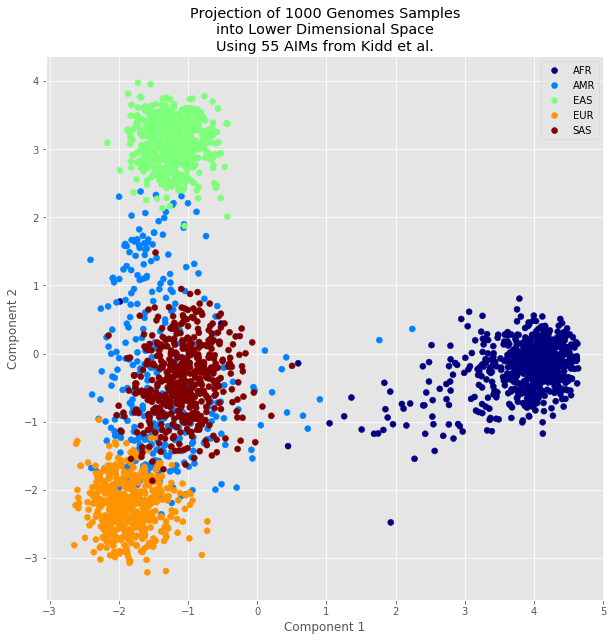

In [14]:
plot_samples(X_emb, x_component=1, y_component=2)